# This notebook explores different machine learning modelling techniques and checks the profit gained by each models.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib
from xgboost import XGBRegressor, XGBClassifier, plot_importance
import datetime
import statsmodels
from scipy import stats
from scipy.stats import norm
import pykalman
import sklearn
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
import pickle
%matplotlib inline

In [150]:
# this function parses date into datetime format
def date_parser(string):
    return datetime.datetime.fromtimestamp(int(string))

# this function calculates division operation
def divide_square(x,y):
    if y == 0:
        return x
    else:
        return x/(y*y)

# custom reward function to calculate square error between actual and predicted value. we penalize by .5 when the predicted value
# are of same sign and abs(pred) > abs(actual), we penalize by 1.5 if negative actual value is less than the predicted value
def reward_difference(pred, actual):
    if actual < 0 and pred < actual:
        return 0.25 * (actual-pred) * (actual - pred)
    elif actual < 0 and pred > actual:
        return 2.25 * (actual-pred) * (actual - pred)
    elif actual > 0 and pred > 0 and pred < actual:
        return 0.25 * (actual-pred) * (actual - pred)
    else:
        return (actual-pred) * (actual - pred)

# this function calculates MAPE    
def mape(y_true, y_pred): 
    return np.mean(np.abs(map(divide,y_true - y_pred,y_true))) * 100

# function to calculate reward MAPE
def reward_mape(y_true, y_pred):
    return np.mean(np.sqrt(map(divide_square, map(reward_difference, y_pred , y_true), y_true))) * 100

# function to get cutoff value between different predictions
def max_min(x,y):
    if x > 0 and y > 0.01:
        return y
    elif x < 0 and y < -0.01:
        return y
    else:
        return x
    
def sigmoid(x):
    return np.exp(x)/(1+np.exp(x))

def inv_sigmoid(y):
    return np.log(y/(1-y))

we check the time difference between consecutive trades to figure out the average number of trades happen in 5 minutes. this will be assigned to LAG number.

In [22]:
data = pd.read_csv('../data/coinbaseUSD.csv',names=['time','price','volume'],nrows=200000,parse_dates=['time'],date_parser=date_parser)
data = data[5500:].reset_index(drop=True)
data['date'] = data.time.apply(lambda x: x.date())
data['daytime'] = data.time.apply(lambda x: x.time())
print ('Number of trading days is ' + str(len(data.date.unique())))
alltimes = list(data.time)
timediffs = pd.DataFrame([(t - s).seconds for s, t in zip(alltimes, alltimes[1:])])
print ('time differences between consecutive trades in seconds :')
print (timediffs.describe())
data = data[['date','daytime','volume','price']]
del alltimes

Number of trading days is 20
                   0
count  194499.000000
mean        8.384007
std        28.481867
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max      2159.000000

[8 rows x 1 columns]


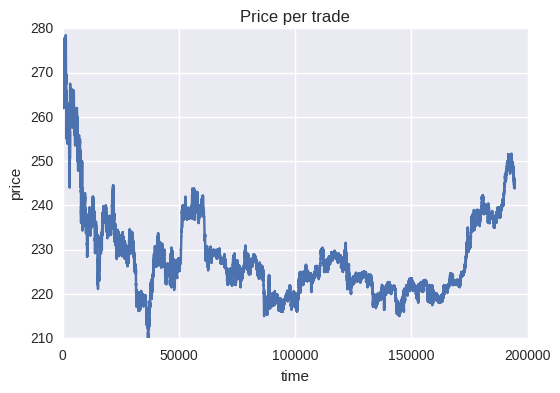

In [23]:
plt.plot(data.price)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Price per trade')
#plt.gcf().autofmt_xdate()
plt.show()

It seems that prices are highly affected by lagged prices over short period. also the timeseries contains volatile jumps.

In [25]:
LAG = 50
#LAG = int(300/timediffs.values.mean())
#print ('Number of lags taken as ' + str(LAG))
del timediffs
for i in range(1,LAG+1):
    var = 'price' + str(i)
    data[var] = data.price.shift(i)
data['target'] = data.price.shift(-1)    
data = data.dropna()    
data.target = (data.target - data.price)/data.price * 100
target = data.target

Number of lags taken as 71


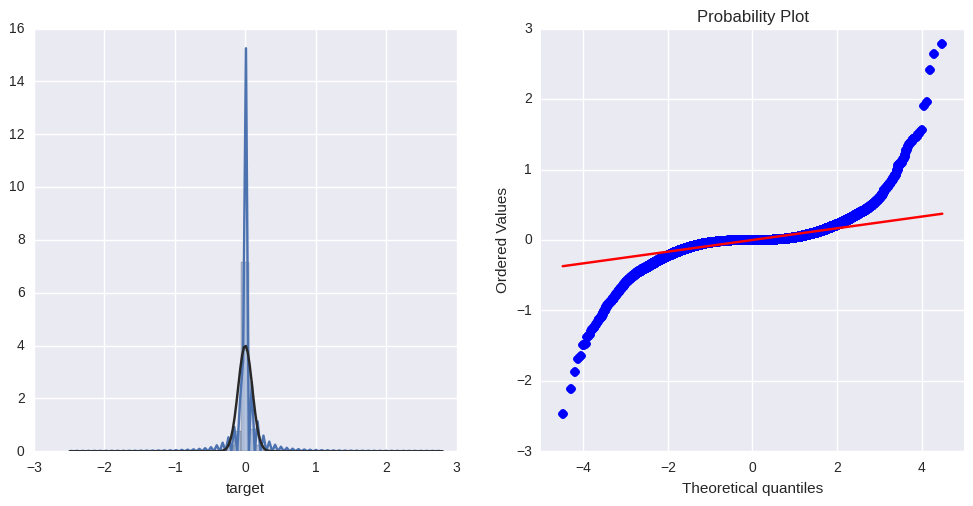

count    194428.000000
mean         -0.000005
std           0.099663
min          -2.467011
25%          -0.012698
50%           0.000000
75%           0.013049
max           2.778000
Name: target, dtype: float64


In [26]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,12))
plt.subplot(2,2,1)
sns.distplot(data.target,fit=norm)
plt.subplot(2,2,2)
res = stats.probplot(data.target,plot=plt)
plt.show()
print ('Return % in consecutive trades :')
print (data.target.describe())

The return values follow almost normality. linear regression models can perform good in this scenario.

In [27]:
train_size = .8
train = data.iloc[:int(data.shape[0]*train_size)].reset_index(drop=True)
test = data.iloc[int(data.shape[0]*train_size):].reset_index(drop=True)
del data

In [28]:
# we take lagged prices, current trade price and volume as regressor
regressors = [i for i in train.columns if i == 'price' or (i == 'volume') or ('price' in i and int(i.replace('price','')) <= LAG)]

we fit bayesian regressor model to predict the return in the next trade. we use hyperopt to get the optimal hyperparameters

In [29]:
def hyperopt_regression(params):
    clf = BayesianRidge(**params)
    clf.fit(train[regressors],train.target)
    pred = clf.predict(test[regressors])
    return mean_squared_error(pred, test.target)

space4br = {
    'n_iter': hp.choice('n_iter', [200,300,400,500,600,1000]),
    'tol': hp.choice('tol', [.005,.001,.0005,.0001,.00005,.00001,.000001,.0000001]),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
    'normalize': hp.choice('normalize', [True, False]),
    'lambda_1': hp.choice('lambda_1', [0,.5,1,2,5,10,20]),
    'lambda_2': hp.choice('lambda_2', [0,.5,1,2,5,10,20]),
    'alpha_1': hp.choice('alpha_1', [0,.5,1,2,5,10,20]),
    'alpha_2': hp.choice('alpha_2', [0,.5,1,2,5,10,20])                
}

def f(params):
    acc = hyperopt_regression(params)
    return {'loss': acc, 'status': STATUS_OK}

In [30]:
trials = Trials()
best = fmin(f, space4br, algo=tpe.suggest, max_evals=200, trials=trials)
print ('best:')
print (best)

best:
{'normalize': 0, 'n_iter': 3, 'lambda_1': 0, 'lambda_2': 5, 'fit_intercept': 1, 'alpha_2': 0, 'tol': 0, 'alpha_1': 4}


In [31]:
best_params = space_eval(space4br, best)
clf = BayesianRidge(**best_params)
clf.fit(train[regressors],train.target)
train['pred_br'] = clf.predict(train[regressors])
joblib.dump(clf, '../saved_models/regression_model2.pkl')
pred = clf.predict(test[regressors])
test['pred_br'] = pred
print (np.sqrt(mean_squared_error(pred, test.target)))

0.0829527254968


Lets formulate a basic trading strategy. When current position is <= 0 and price diff >= buy limit we buy. If current
position is >= 0 and price diff <= sell limit we sell. Else we hold the position. we check the best possible profit using simple buy and sell limit. 

In [32]:
def backtest(pred,actual_price,buy_limit,sell_limit,current_pos=0,cum_profit=0,current_balance=0):
    profit = []
    balance = []
    for index, i in enumerate(pred):
        if i >= buy_limit and current_pos <= 0:
            current_pos = 1
            buy_price = actual_price[index]
            current_balance -= buy_price
        if i <= sell_limit and current_pos == 1:
            current_pos = 0
            sell_price = actual_price[index] 
            current_balance += sell_price
            cum_profit = current_balance
        profit.append(cum_profit)
        balance.append(current_balance)
    return balance, profit

In [33]:
space4st = {
    'buy_limit': hp.choice('buy_limit', [.6,.65,.7,.75,.8,.85,.9]),
    'sell_limit': hp.choice('sell_limit', [.05,.1,.15,.2,.25,.3,.35])
}

def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

In [34]:
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:', best)

('best:', {'sell_limit': 6, 'buy_limit': 1})


In [35]:
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
print ("buy limit is return of " + str(buy_limit) + '%')
print ("sell limit is return of " + str(sell_limit) + '%')
balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)

buy limit is return of 0.00431816219017%
sell limit is return of -0.00432881693433%


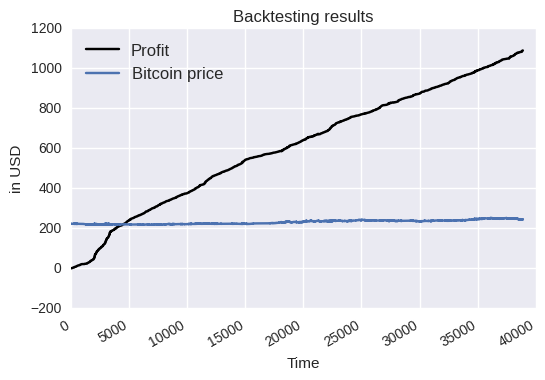

In [36]:
#ax = plt.gca()
#ax2 = ax.twinx()
plt.title("Backtesting results")
#ax2.plot(profit, color='black',label="Profit")
#ax.plot(test.price)
plt.plot(profit, color='black',label="Profit")
plt.plot(test.price,label="Bitcoin price")
plt.xlabel("Time")
plt.ylabel('in USD')
plt.legend(loc="best", prop=dict(size=12))
plt.gcf().autofmt_xdate()
plt.show()

In [39]:
print "Max profit at", test.date.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))] 
print "Initial profit at", test.date.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0] 
print "Final profit at", test.date.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1] 

 Max profit at 2015-02-14 with profit of USD  1089.12 and bitcoin price USD  244.44
Initial profit at 2015-02-11 with profit of USD  0 and bitcoin price USD  222.66
Final profit at 2015-02-14 with profit of USD  1089.12 and bitcoin price USD  244.22


Now we replicate the same strategy for extratrees regressor

In [42]:
def hyperopt_extratrees(params):
    clf = ExtraTreesRegressor(**params)
    clf.fit(train[regressors],train.target)
    pred = clf.predict(test[regressors])
    return mean_squared_error(pred, test.target)

space4et = {
    'n_estimators': hp.choice('n_estimators', [50,100,200,300,500,800]),
    'max_features': hp.choice('max_features', ["auto","sqrt","log2"]),
    'max_depth': hp.choice('max_depth', [5,8,15,30]),
    'min_samples_split': hp.choice('min_samples_split',[2,5,10,15,100]),
    'min_samples_leaf': hp.choice('min_samples_leaf',[2,5,10])
}

def f(params):
    acc = hyperopt_extratrees(params)
    return {'loss': acc, 'status': STATUS_OK}

In [43]:
trials = Trials()
best = fmin(f, space4et, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

best:
{'max_features': 0, 'min_samples_split': 4, 'n_estimators': 2, 'max_depth': 3, 'min_samples_leaf': 1}


In [44]:
best_params = space_eval(space4et, best)
clf = ExtraTreesRegressor(**best_params)
clf.fit(train[regressors],train.target)
train['pred_et'] = clf.predict(train[regressors])
joblib.dump(clf, '../saved_models/extratrees_model2.pkl')
pred = clf.predict(test[regressors])
test['pred_et'] = pred
print (np.sqrt(mean_squared_error(pred, test.target)))

0.0847748742309


In [45]:
def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

In [46]:
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
print 'best:', best

best: {'sell_limit': 6, 'buy_limit': 0}


In [47]:
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
print ("buy limit is return of " + str(buy_limit) + '%')
print ("sell limit is return of " + str(sell_limit)+ '%')
balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)

buy limit is return of 0.0%
sell limit is return of -0.00432881693433%


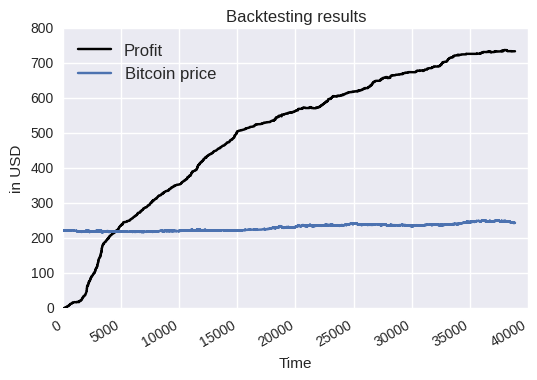

In [48]:
#ax = plt.gca()
#ax2 = ax.twinx()
plt.title("Backtesting results")
#ax2.plot(profit, color='black',label="Profit")
#ax.plot(test.price)
plt.plot(profit, color='black',label="Profit")
plt.plot(test.price,label="Bitcoin price")
plt.xlabel("Time")
plt.ylabel('in USD')
plt.legend(loc="best", prop=dict(size=12))
plt.gcf().autofmt_xdate()
plt.show()

In [49]:
print "Max profit at", test.date.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))] 
print "Initial profit at", test.date.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0] 
print "Final profit at", test.date.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1] 

Max profit at 2015-02-14 with profit of USD  738.15 and bitcoin price USD  249.81
Initial profit at 2015-02-11 with profit of USD  0 and bitcoin price USD  222.66
Final profit at 2015-02-14 with profit of USD  734.48 and bitcoin price USD  244.22


we see that extratrees is performing worse than the bayesian regression. as the data is noisy, there is a possibility of overfitting for the non linear models. we next apply neural network as a stacker on top of ET and BR predicted value

In [52]:
ann_regressors = list(set(list(train.columns)) - set(['date','daytime','target']))

In [53]:
def hyperopt_nn(params):
    clf = MLPRegressor(**params)
    clf.fit(train[ann_regressors],train.target)
    pred = clf.predict(test[ann_regressors])
    return mean_squared_error(pred, test.target)

size = len(ann_regressors)

space4nn = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(size,size/2),(size*2,size),(size,size),(size/2,size)]),
    'alpha': hp.choice('alpha', [1,.1,.01,.05,.001,.0001]),
    'learning_rate_init': hp.choice('learning_rate_init', [.01,.005,.001,.0001])
}

def f(params):
    acc = hyperopt_nn(params)
    return {'loss': acc, 'status': STATUS_OK}

In [54]:
trials = Trials()
best = fmin(f, space4nn, algo=tpe.suggest, max_evals=50, trials=trials)
print ('best:')
print (best)

best:
{'alpha': 3, 'learning_rate_init': 1, 'hidden_layer_sizes': 3}


In [56]:
best_params = space_eval(space4nn, best)
clf = MLPRegressor(**best_params)
clf.fit(train[ann_regressors],train.target)
joblib.dump(clf, '../saved_models/nn_model2.pkl')
pred = clf.predict(test[ann_regressors])
print (np.sqrt(mean_squared_error(pred, test.target)))

0.132055225899


In [57]:
def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

In [58]:
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
print 'best:', best

best: {'sell_limit': 0, 'buy_limit': 0}


In [59]:
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
print ("buy limit is return of " + str(buy_limit) + '%')
print ("sell limit is return of " + str(sell_limit)+ '%')
balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)

buy limit is return of 0.0%
sell limit is return of -0.135078347625%


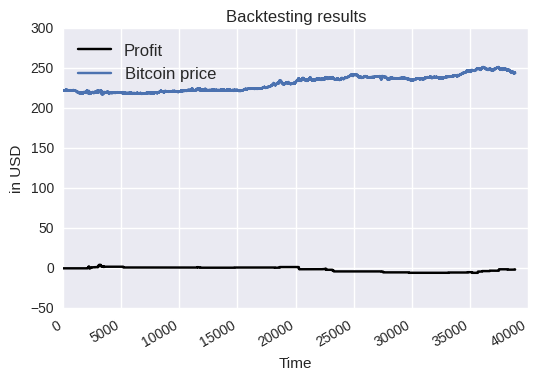

In [60]:
#ax = plt.gca()
#ax2 = ax.twinx()
plt.title("Backtesting results")
#ax2.plot(profit, color='black',label="Profit")
#ax.plot(test.price)
plt.plot(profit, color='black',label="Profit")
plt.plot(test.price,label="Bitcoin price")
plt.xlabel("Time")
plt.ylabel('in USD')
plt.legend(loc="best", prop=dict(size=12))
plt.gcf().autofmt_xdate()
plt.show()

In [61]:
print "Max profit at", test.date.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))] 
print "Initial profit at", test.date.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0] 
print "Final profit at", test.date.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1] 

Max profit at 2015-02-12 with profit of USD  4.4 and bitcoin price USD  221.1
Initial profit at 2015-02-11 with profit of USD  0 and bitcoin price USD  222.66
Final profit at 2015-02-14 with profit of USD  -1.37 and bitcoin price USD  244.22


we see the worst performance by neural network. we stick to linear models for simplicity. in future we will smoothen the return function and use non linear models.

we now do more explorations. we check the accuracy of cut off model. i.e. - if the abs(extratree prediction) > .01 and both predictions are of same sign then we choose the extratrees value, else we choose the regression value.

In [113]:
pred_cutoff = map(max_min, test['pred_br'], test['pred_et'])
print np.sqrt(mean_squared_error(pred_cutoff,test.target))

0.0872333553089


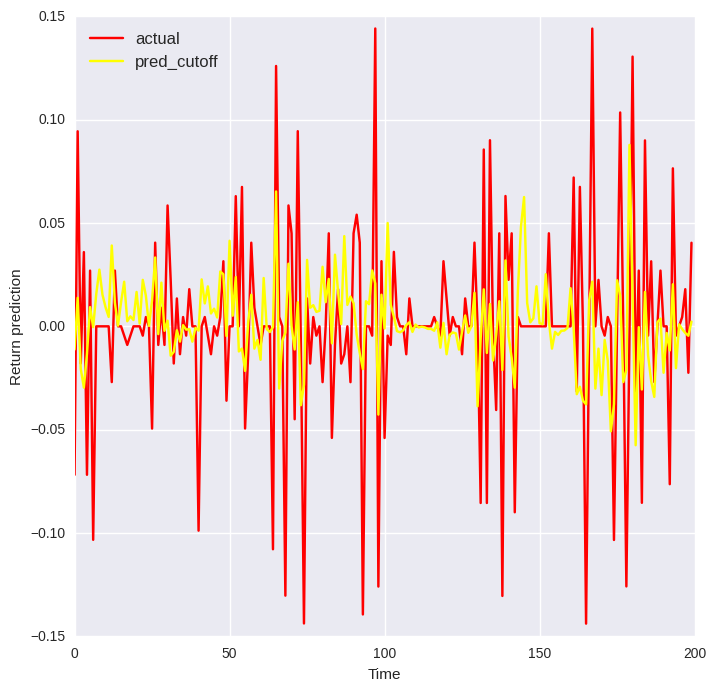

In [124]:
plt.figure(figsize=(8,8))
plt.plot(test.target[:200],color='red',label='actual')
plt.plot(pred_cutoff[:200],color='yellow',label='pred_cutoff')
plt.xlabel("Time")
plt.ylabel('Return prediction')
plt.legend(loc="best", prop=dict(size=12))
plt.show()

In [116]:
pred = pred_cutoff
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
print (max(profit))

('best:', {'sell_limit': 5, 'buy_limit': 2})
buy limit is return of 0.00457980306848%
sell limit is return of -0.00457372850347%
1080.76


we see that the cut off model generates little less profit than the regressor model. now we change our error function from MSE to reward MAPE and see if the regressor model can do better

In [120]:
def hyperopt_regression(params):
    clf = BayesianRidge(**params)
    clf.fit(train[regressors],train.target)
    pred = clf.predict(test[regressors])
    return reward_mape(test.target,pred)

def f(params):
    acc = hyperopt_regression(params)
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4br, algo=tpe.suggest, max_evals=200, trials=trials)

best_params = space_eval(space4br, best)
clf5 = BayesianRidge(**best_params)
clf5.fit(train[regressors],train.target)
pred5 = clf5.predict(test[regressors])
print (reward_mape(test.target,pred5))
print (np.sqrt(mean_squared_error(test.target,pred5)))

def f(params):
    buy_limit = np.percentile(target, params['buy_limit']*100)
    sell_limit = np.percentile(target, params['sell_limit']*100)
    balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
    val = max(profit)
    return {'loss': -val, 'status': STATUS_OK}

pred = pred5
trials = Trials()
best = fmin(fn=f, space=space4st, algo=tpe.suggest, max_evals=50, trials=trials)
best_params = space_eval(space4st, best)
buy_limit = np.percentile(target, best_params['buy_limit']*100)
sell_limit = np.percentile(target, best_params['sell_limit']*100)
print ("buy limit is return of " + str(buy_limit) + '%')
print ("sell limit is return of " + str(sell_limit)+ '%')
balance, profit = backtest(pred,list(test.price),buy_limit,sell_limit)
print (max(profit))

best:
{'normalize': 0, 'n_iter': 4, 'lambda_1': 5, 'lambda_2': 0, 'fit_intercept': 0, 'alpha_2': 5, 'tol': 2, 'alpha_1': 0}
124.279964903
('best:', {'sell_limit': 5, 'buy_limit': 2})
buy limit is return of 0.00457980306848%
sell limit is return of -0.00457372850347%
1089.76


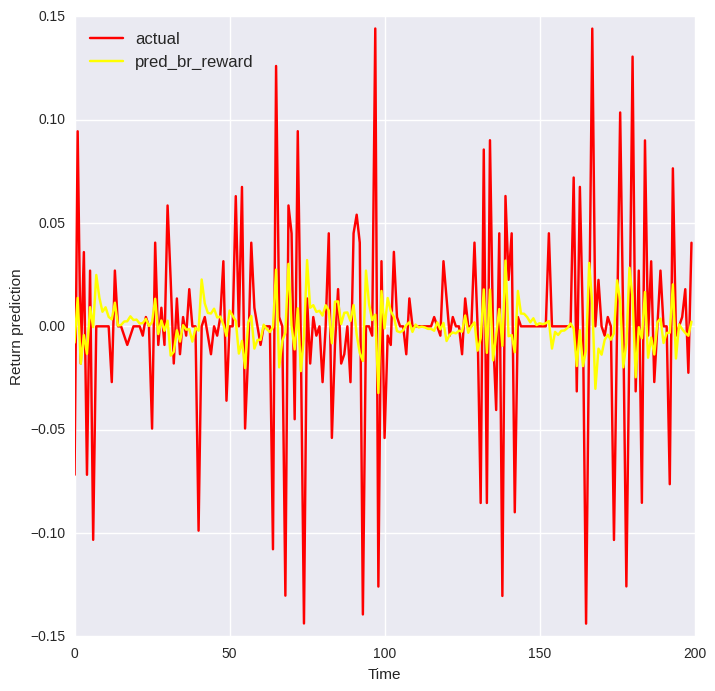

In [125]:
plt.figure(figsize=(8,8))
plt.plot(test.target[:200],color='red',label='actual')
plt.plot(pred5[:200],color='yellow',label='pred_br_reward')
plt.xlabel("Time")
plt.ylabel('Return prediction')
plt.legend(loc="best", prop=dict(size=12))
plt.show()

the results are indeed good. we will work with this error function.

we will now do a slight modification in the target variable. we take target variable as exp(target) can check if the model can predict more accurately or not. first we check the plot of the target variable

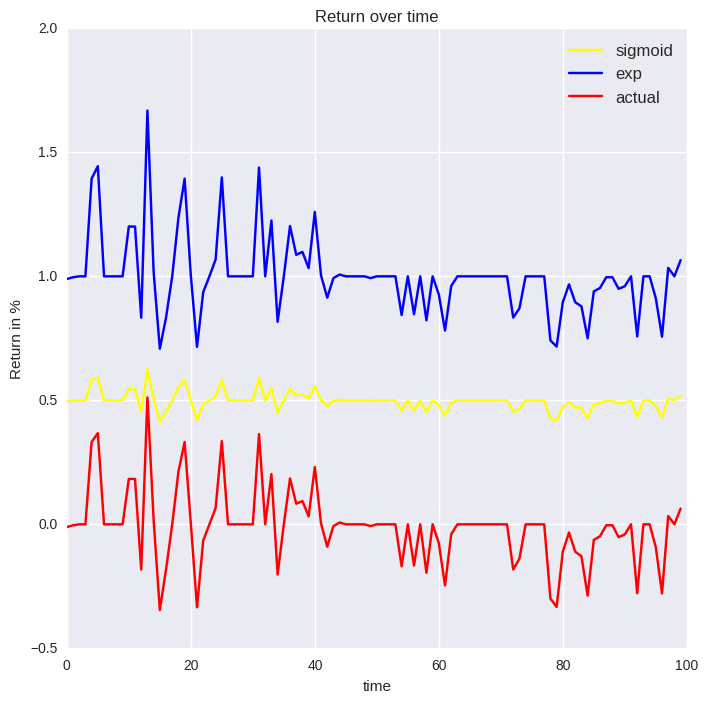

In [153]:
plt.figure(figsize=(8,8))
plt.plot(map(sigmoid,target[:100]),color = 'yellow',label = 'sigmoid')
plt.plot(np.exp(target[:100]),color = 'blue',label = 'exp')
plt.plot(target[:100],color = 'red',label = 'actual')
plt.xlabel('time')
plt.ylabel('Return in %')
plt.title('Return over time')
plt.legend(loc="best", prop=dict(size=12))
#plt.gcf().autofmt_xdate()
plt.show()

In [151]:
clf_test = BayesianRidge()
clf_test.fit(train[regressors],map(sigmoid,train.target))
pred_test = map(inv_sigmoid,clf_test.predict(test[regressors]))
print (np.sqrt(mean_squared_error(pred_test,test.target)))

0.0830309828335


though the sigmoid function reduces the range of the target variable, it seems that it does not improve our model performance.